In [1]:
###############################################################################################################################################################
#----------------------------------------------------------------------SETUP-----------------------------------------------------------------------------------
###############################################################################################################################################################

In [2]:
#Imports
#Data handeling
import numpy as np
import pandas as pd

#Data visualsiation
import matplotlib.pyplot as plt
import seaborn as sns
from skimpy import skim # Cool package that makes visuslising the data very easy and intutative

#Model evalauations
from sklearn.metrics import confusion_matrix, r2_score, accuracy_score, f1_score, roc_curve, auc

#Data processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.decomposition import PCA

#Spark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import StringIndexer

#Model exporting
import pickle

In [3]:
#Settings

#Solves the following envioment error:
#   "Python in worker has different version 3.10 than that in driver 3.11, PySpark cannot run with different minor versions. 
#       Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set."

import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [4]:
###############################################################################################################################################################
#----------------------------------------------------------------------DATA PROCESSING-------------------------------------------------------------------------
###############################################################################################################################################################

In [5]:
#Create Spark session
spark = SparkSession.builder.appName("Covid_Analysis").getOrCreate()

In [6]:
#Load data
spark_df = spark.read.csv('covid_19.csv', header=True, inferSchema=True)
y_label = 'Is_Covid_True'

print((spark_df.count(), len(spark_df.columns)))

(1000000, 30)


In [7]:
#Whole dataframe overview
spark_df.printSchema()

root
 |-- Patient_ID: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Blood_Pressure: double (nullable = true)
 |-- Heart_Rate: double (nullable = true)
 |-- Fever: boolean (nullable = true)
 |-- Cough: boolean (nullable = true)
 |-- Sore_Throat: boolean (nullable = true)
 |-- Fatigue: boolean (nullable = true)
 |-- Headache: boolean (nullable = true)
 |-- Breathlessness: boolean (nullable = true)
 |-- Loss_of_Smell_Taste: boolean (nullable = true)
 |-- Diarrhea: boolean (nullable = true)
 |-- Chest_Pain: boolean (nullable = true)
 |-- Body_Ache: boolean (nullable = true)
 |-- Runny_Nose: boolean (nullable = true)
 |-- Vomiting: boolean (nullable = true)
 |-- Diabetes: boolean (nullable = true)
 |-- Hypertension: boolean (nullable = true)
 |-- Asthma: boolean (nullable = true)
 |-- Obesity: boolean (nullable = true)
 |-- Smoking: boolean (nullable = true)
 |-- Vaccinated: boolean (nullable = tru

In [8]:
#Remove uneeded columns
spark_df = spark_df.drop('Name', 'Patient_ID')
print((spark_df.count(), len(spark_df.columns)))

(1000000, 28)


In [9]:
#Remove nulls
print((spark_df.count(), len(spark_df.columns)))
spark_df = spark_df.dropna()
print((spark_df.count(), len(spark_df.columns)))

(1000000, 28)
(449882, 28)


In [10]:
#Remove duplicates
print((spark_df.count(), len(spark_df.columns)))
spark_df = spark_df.dropDuplicates()
print((spark_df.count(), len(spark_df.columns)))

(449882, 28)
(449881, 28)


In [11]:
#Encoding booleans
#Soruce: https://sparktpoint.com/pyspark-find-dataframe-column-datatypes/
boolean_columns = [column[0] for column in spark_df.dtypes if column[1] == 'boolean']
print(boolean_columns)

for column in boolean_columns:
    #Source: https://www.statology.org/pyspark-convert-boolean-to-int/
    spark_df = spark_df.withColumn(column, when(col(column) == True, 1).otherwise(0))

['Fever', 'Cough', 'Sore_Throat', 'Fatigue', 'Headache', 'Breathlessness', 'Loss_of_Smell_Taste', 'Diarrhea', 'Chest_Pain', 'Body_Ache', 'Runny_Nose', 'Vomiting', 'Diabetes', 'Hypertension', 'Asthma', 'Obesity', 'Smoking', 'Vaccinated', 'Travel_History', 'Contact_with_Positive', 'ICU_Admission', 'Is_Covid_True']


In [12]:
#Encode the single string column
#Soruce: https://medium.com/@big_data_landscape/spark-machine-learning-mllib-stringindexer-b91e3f6b8905
#a temp feature needs to be created for the encoded gender as the StringIndexer doesnt allow overwritting
indexer = StringIndexer(inputCol='Gender', outputCol='gender_temp')
spark_df = indexer.fit(spark_df).transform(spark_df)
spark_df = spark_df.drop('Gender')
spark_df = spark_df.withColumnRenamed('gender_temp', 'Gender')

In [13]:
###############################################################################################################################################################
#----------------------------------------------------------------------EXPLORATORY ANALYSIS--------------------------------------------------------------------
###############################################################################################################################################################

In [14]:
#Convert the data to pandas to ease of use and to enable graphing
df = spark_df.toPandas()

In [15]:
#Whole dataframe overview after cleaning
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 449881 │ │ int32       │ 22    │                                                          │
│ │ Number of columns │ 28     │ │ float64     │ 6     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━┳━━━━━━┳━━━━━━┳━━━━━━┳━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name               ┃ NA  ┃ NA %   ┃ mean      ┃ sd       ┃ p0  ┃ p25  ┃ p50  ┃ p75  ┃ p100 ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━╇━━━━━━╇━━━━━━╇━━━━━━╇━━━━━━╇━━━━━━━━┩  │
│ │ Age                       │   0 │      0 │     49.94 │     28.6 │   1 │   25 │   50 │   75 │   99 │ ▇▇▇▇▇▇ │  │
│ │ Blood_Pressure            │   0 │      0 │     129.5 │    28.81 │  80 │  105 │  129 │  154 │  179 │ ▇▇▇▇▇▇ │  │
│ │ Heart_Rate                │   0 │      0 │     89.46 │    17.32 │  60 │   74 │   89 │  104 │  119 │ ▇▇▇▇▇▇ │  │
│ │ Fever                     │   0 │      0 │     0.299 │   0.4578 │   0 │    0 │    0 │    1 │    1 │ ▇    ▃ │  │
│ │ Cough                     │   0 │      0 │    0.3994 │   0.4898 │   0 │    0 │    0 │    1 │    1 │ ▇    ▅ │  │
│ │ Sore_Throat               │   0 │      0 │       0.3 │   0.4583 │   0 │    0 │    0 │    1 │    1 │ ▇    ▃ │  │
│ │ Fatigue                   │   0 │      0 │    0.4005 │     0.49 │   0 │    0 │    0 │    1 │    1 │ ▇    ▅ │  │
│ │ Headache                  │   0 │      0 │    0.3991 │   0.4897 │   0 │    0 │    0 │    1 │    1 │ ▇    ▅ │  │
│ │ Breathlessness            │   0 │      0 │    0.1994 │   0.3996 │   0 │    0 │    0 │    0 │    1 │ ▇    ▂ │  │
│ │ Loss_of_Smell_Taste       │   0 │      0 │    0.1511 │   0.3581 │   0 │    0 │    0 │    0 │    1 │ ▇    ▁ │  │
│ │ Diarrhea                  │   0 │      0 │    0.0997 │   0.2996 │   0 │    0 │    0 │    0 │    1 │ ▇    ▁ │  │
│ │ Chest_Pain                │   0 │      0 │   0.05018 │   0.2183 │   0 │    0 │    0 │    0 │    1 │   ▇    │  │
│ │ Body_Ache                 │   0 │      0 │       0.3 │   0.4583 │   0 │    0 │    0 │    1 │    1 │ ▇    ▃ │  │
│ │ Runny_Nose                │   0 │      0 │    0.2512 │   0.4337 │   0 │    0 │    0 │    1 │    1 │ ▇    ▃ │  │
│ │ Vomiting                  │   0 │      0 │    0.1008 │   0.3011 │   0 │    0 │    0 │    0 │    1 │ ▇    ▁ │  │
│ │ Diabetes                  │   0 │      0 │   0.09958 │   0.2994 │   0 │    0 │    0 │    0 │    1 │ ▇    ▁ │  │
│ │ Hypertension              │   0 │      0 │    0.1506 │   0.3576 │   0 │    0 │    0 │    0 │    1 │ ▇    ▁ │  │
│ │ Asthma                    │   0 │      0 │    0.1001 │   0.3001 │   0 │    0 │    0 │    0 │    1 │ ▇    ▁ │  │
│ │ Obesity                   │   0 │      0 │    0.1196 │   0.3245 │   0 │    0 │    0 │    0 │    1 │ ▇    ▁ │  │
│ │ Smoking                   │   0 │      0 │    0.1002 │   0.3002 │   0 │    0 │    0 │    0 │    1 │ ▇    ▁ │  │
│ │ Vaccinated                │   0 │      0 │    0.5989 │   0.4901 │   0 │    0 │    1 │    1 │    1 │ ▅    ▇ │  │
│ │ Travel_History            │   0 │      0 │    0.0501 │   0.2182 │   0 │    0 │    0 │    0 │    1 │   ▇    │  │
│ │ Contact_with_Positive     │   0 │      0 │    0.2015

array([[<Axes: title={'center': 'Is_Covid_True'}>]], dtype=object)

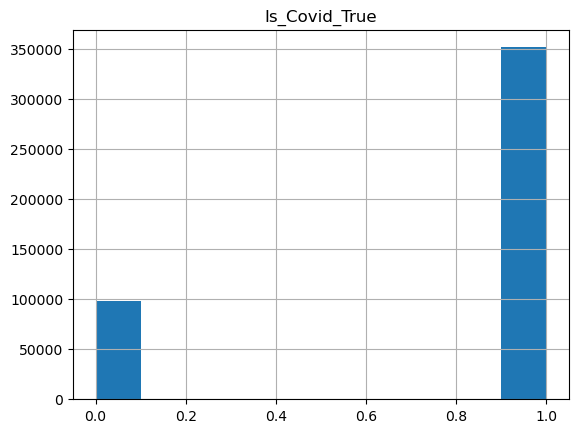

In [16]:
#check output feature distrobusion
df.hist(column=y_label)

<Axes: >

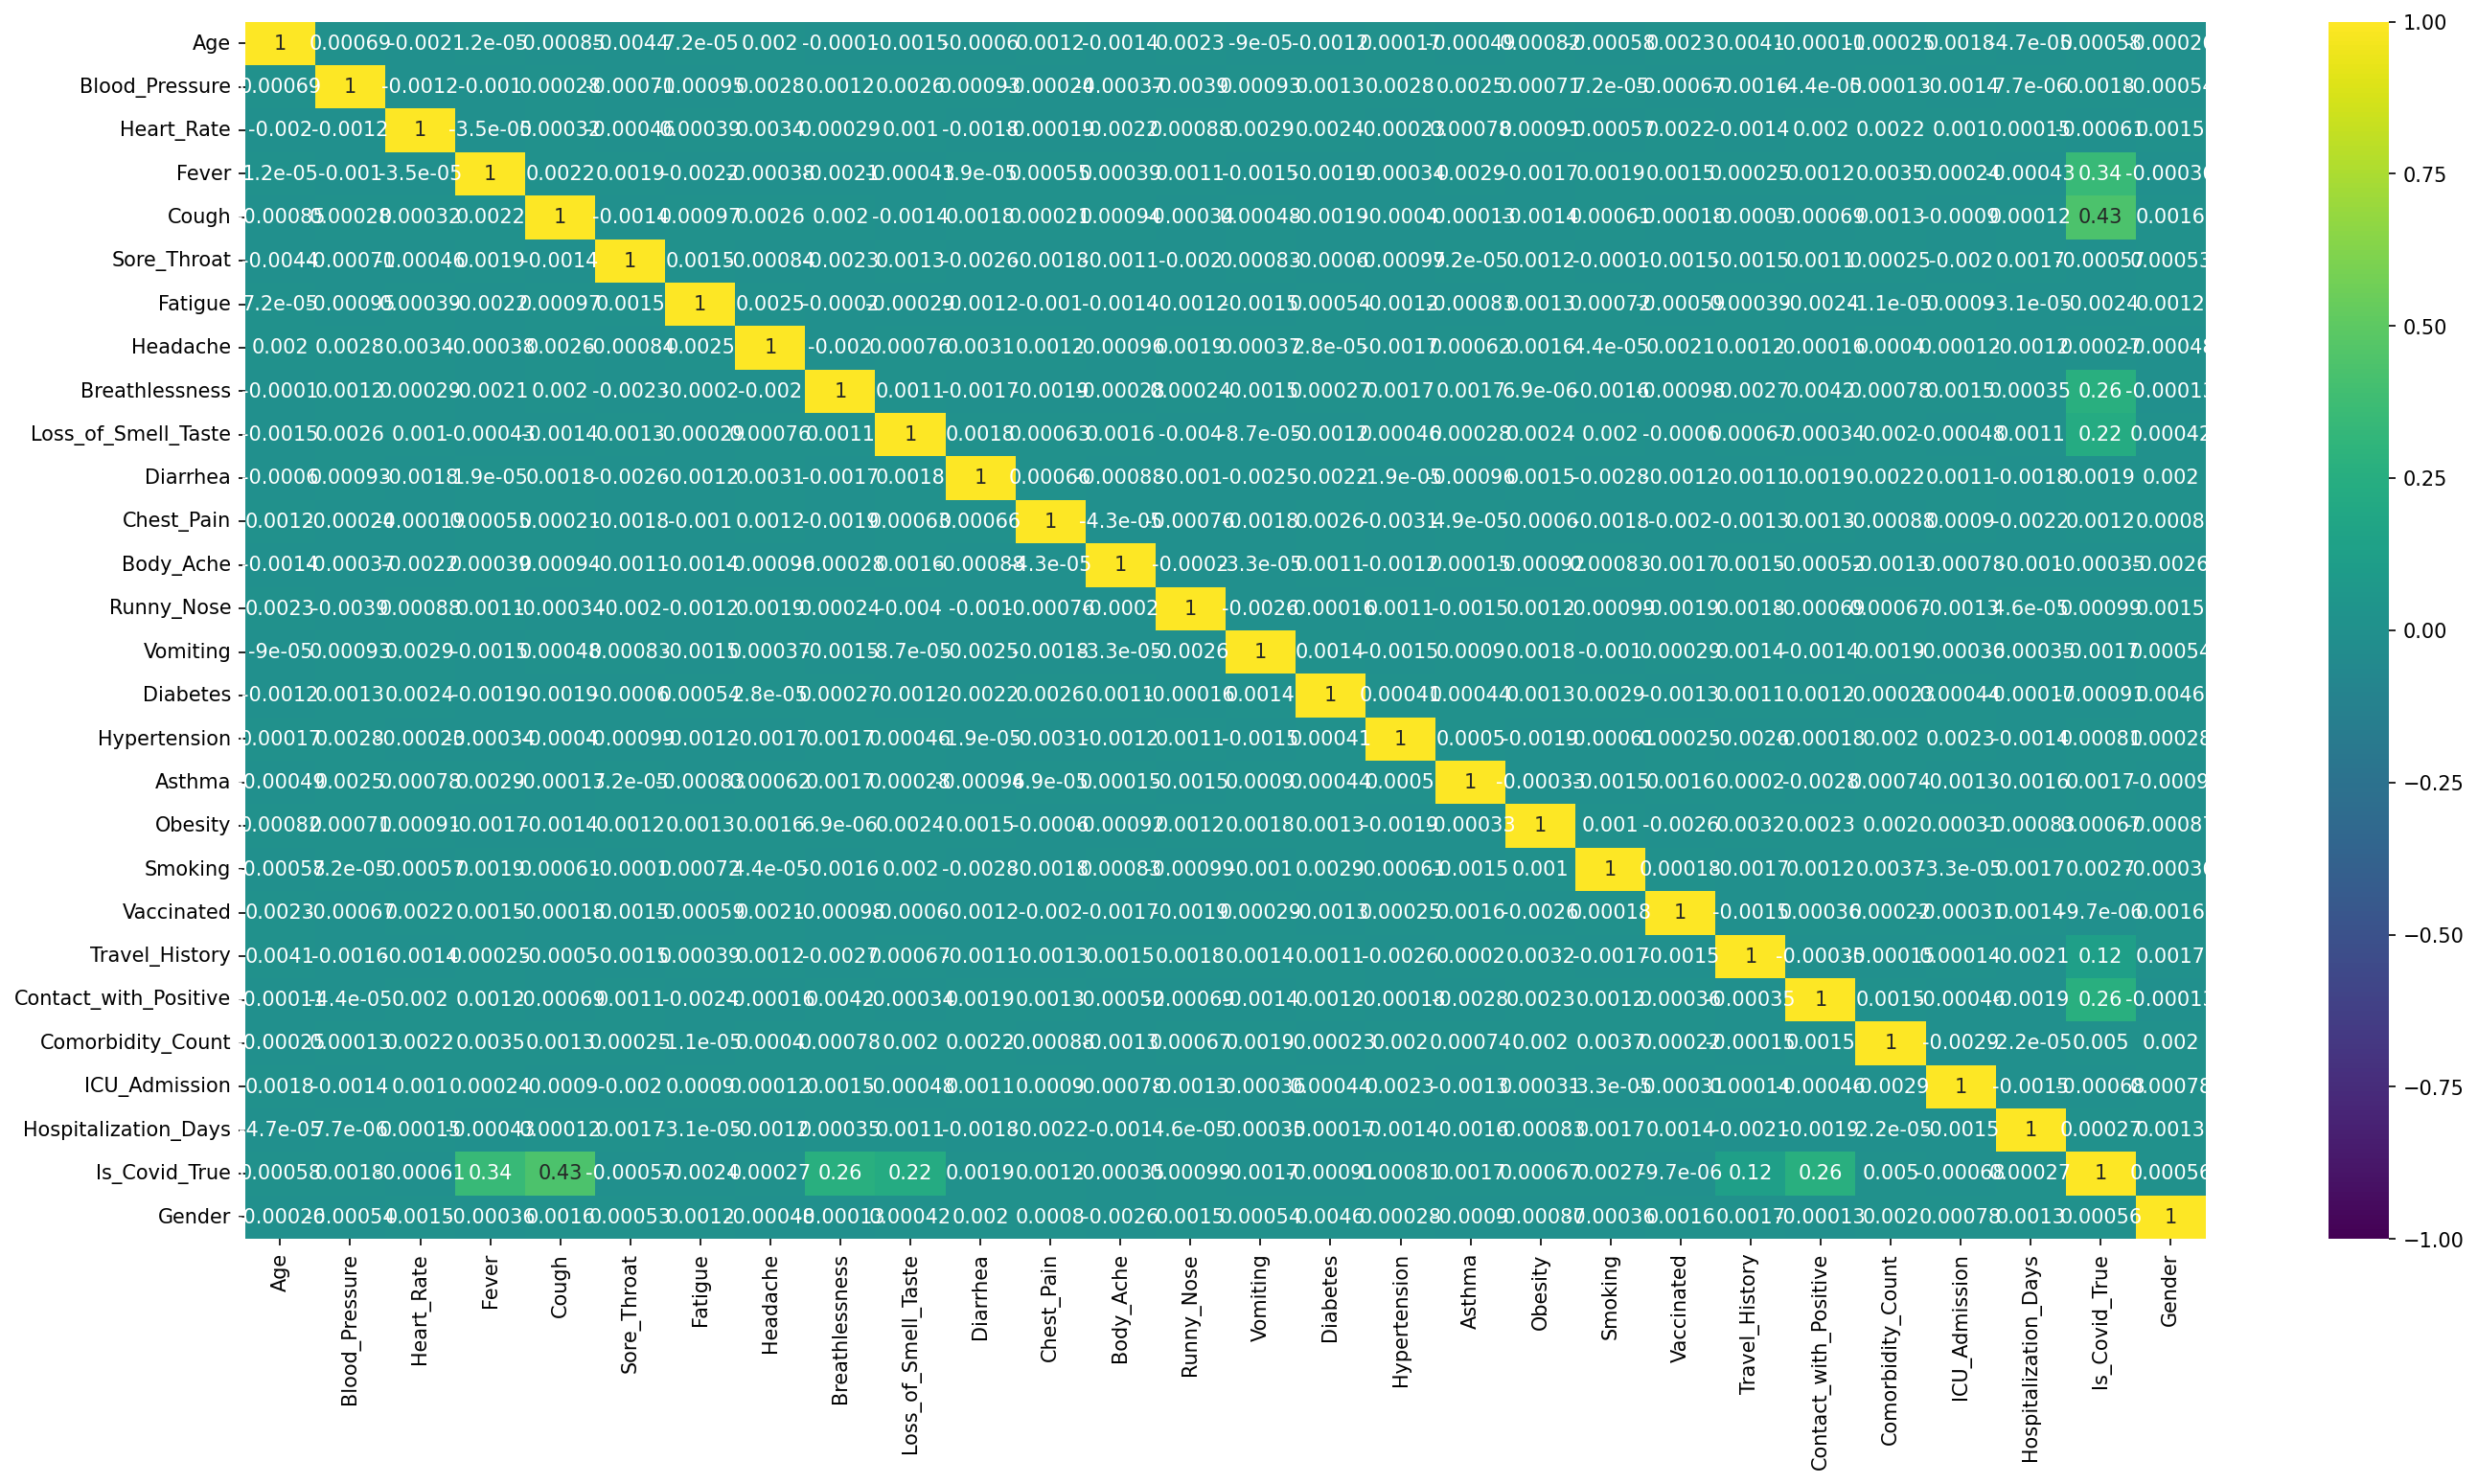

In [17]:
#heatmap
plt.figure(figsize=(22,11),dpi=150)
sns.heatmap(df.corr(),annot=True,cmap='viridis',vmin=-1,vmax=1)

In [18]:
###############################################################################################################################################################
#----------------------------------------------------------------------CREATING THE MODELS---------------------------------------------------------------------
###############################################################################################################################################################

In [19]:
#Custom logistic regression class

#Sources:
#   https://realpython.com/logistic-regression-python/
#       Methadology guide, mathermatics expalations, classification performance
#   https://www.w3schools.com/python/python_classes.asp
#       How to make and interact with a class in the way that was needed in this assigment
#   https://developer.ibm.com/articles/implementing-logistic-regression-from-scratch-in-python/
#       Basic logistic regression model/algorigm used as foudnation
#   https://medium.com/technology-through-the-prism/implementation-of-logistic-regression-without-using-built-in-library-90e2afffa137
#       More advanced logisc regression model/algorigm
#   https://medium.com/@robdelacruz/logistic-regression-from-scratch-7db690fb380b
#       Easy to understand advanced logisc regression model/algorigm
#   https://nadeemm.medium.com/cost-function-loss-function-c3cab1ddffa4
#       Understanding what cost is   
#   https://github.com/scikit-learn/scikit-learn/blob/d5082d32d/sklearn/linear_model/_logistic.py#L810
#       Comaping certain aspects to a professionally created model
#   https://gemini.google.com/app
#       Code explanations, error fixing, code optimisation

#aim was to make a class that can be interacted with the same way a logistic regression model from SKLearn can
#as it is custom custom evalaution can be added, which makes the code clearner and easier to use
class CustomLogisticRegression:

    #Initialse the models paramiters
    def __init__(self, learning_rate=0.01, n_iters=1000):
        #the speed of the gradiant decent weight updates
        self.learning_rate = learning_rate
        #the number of trainign itnerations, same as epoch
        self.max_iterations  = n_iters 
        #the weights of the models algorithm
        self.weights = None
        #the bias of the models algorithm
        self.bias = None
        #the history of the models traning
        self.cost_history = []

    #Forces the output to be between 0 and 1
    #It maps predicted values to probabilities
    #As there are only two possible outputs in the dataset this is all that is needed
    def sigmoid(self, linear_values):
        return 1 / (1 + np.exp(-linear_values))

    #measuers the difference between the predicted and actual values, its the same as cross-entropy loss
    #cost is over the whoel dataset whilst loss is for a single traning example
    def compute_cost(self, y_actual, y_predicted):
        n_samples = len(y_actual)
        #epsilon is use to clip the values to prevent the model form breaking if the predicted value is exactually 0 or 1
        #if its 0 or 1 it can cause log(0) errors
        #Source: https://tariqueakhtar-39220.medium.com/implementing-loss-or-cost-function-in-python-from-scratch-a6906428092e
        epsilon = 1e-15 
        y_predicted = np.clip(y_predicted, epsilon, 1 - epsilon)
        cost = (-1 / n_samples) * np.sum(y_actual * np.log(y_predicted) + (1 - y_actual) * np.log(1 - y_predicted))
        return cost

    #Fits the model to the data
    #In the process the weights and biases are updated to reduce the cost value
    def fit(self, X_input, Y_input):
        n_samples, n_features = X_input.shape

        #initialise the varaibles that are changed as the model learns
        self.weights = np.zeros(n_features)
        self.bias = 0

        #uses gradiant decent to attempt to minize the cost
        #the max_iterations is the number of time that the weights and bias are adjusted
        for i in range(self.max_iterations):

            #creates a linear model of the inputs and the weights, and adding the bias
            #creates a prediction of the outputs using the exisitng weights and bias to find the cost value
            linear_model = np.dot(X_input, self.weights) + self.bias

            #convert the linear predictions to sigmoid probabilities
            predicted_probabilities = self.sigmoid(linear_model)

            #this part is more complex mathermatics
            #it calcuates how changing the weight and bias effects the cost, then updates then in the oposite direction to reduce the cost
            #for the weights it does this for every weights, which is = to the number of features
            #   the .T in the gradients_weights swaps the rows and columns, which is needed for the matrix multiplication (np.dot)
            #   then is calcautes the distance between the actual and predicted values and averages the results using (1 / n_samples)   
            #       the (1 / n_samples) shows how each weight contributes the model, doing this allows for better generalisation
            gradients_weights  = (1 / n_samples) * np.dot(X_input.T, (predicted_probabilities - Y_input))
            #for the bias it calucates a single value to adjust
            #   works the same as the weights but it does not use matrix multiplication or .T as there is only one value
            gradients_bias  = (1 / n_samples) * np.sum(predicted_probabilities - Y_input)

            #change the weights and bias by adjusting the weights down from the origional, timsed by the learning rate to control the decent
            self.weights -= self.learning_rate * gradients_weights
            self.bias -= self.learning_rate * gradients_bias

            #calcuate and store the loss of this iteration/epoch
            cost = self.compute_cost(Y_input, predicted_probabilities)
            self.cost_history.append(cost)

            #print every 100th itertations info
            #its the same as when training a NN the epochs values are printed
            if i % 100 == 0:
                print(f"Iteration {i}/{self.max_iterations}: Cost = {cost}")

    #creates a prediction for one of the class labels
    #uses a threshold to determine if the probability should be placed into 0 or 1
    #the threshold allows for the model to be scewed towards one output label but this corrects it
    def predict(self, X_input, threshold=0.5):
        probabilities = self.predict_probality(X_input)
        return np.where(probabilities >= threshold, 1, 0)

    #used to create a prediction of the data point being a 1
    #this can then be roudned to calcaute if the data point is or isnt a 1, so a 1 or a 0
    #uses matrix multiplication to calcuate the weighted sum of the features
    def predict_probality(self, X_input):
        linear_model = np.dot(X_input, self.weights) + self.bias
        return self.sigmoid(linear_model)



    #Evalaute the models performance using multiple metrics inorder to get a better understidning of the model
    def evaluate(self, X_test, y_test, threshold=0.5):
        #get predicted values to compare to the actual values
        y_pred = self.predict(X_test, threshold)

        #caclaute the metrics using the SKLearn packages
        r2 = r2_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        #print the results
        print(f"R2 Score: {r2}")
        print(f"Accuracy: {accuracy}")
        print(f"F1 Score: {f1}")

    #Generate a confusin matrix inorder to visualiuse the models accuracy
    def plot_confusion_matrix(self, X_test, y_test, threshold=0.5):
        #Get predicted values to compare to the actual values
        y_pred = self.predict(X_test, threshold)

        #Create confusion matrix then plot
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

    #Plot the cost curve, this makes it easier to visualsse the models growth and identify under and overfitting
    #Cost is simular to loss but oer the entire training cycle, not just one iteration or epoch 
    def plot_cost_history(self):
        plt.plot(self.cost_history)
        plt.xlabel('Iterations')
        plt.ylabel('Cost')
        plt.title('Cost Function Convergence')
        plt.show()

    #Generate graph to show the models predicition abiliites
    #Source: https://www.geeksforgeeks.org/how-to-plot-roc-curve-in-python/
    def plot_roc_curve(self, X_test, y_test):
        #Get predicted probabilities
        y_pred_probabilites = self.predict_probality(X_test)

        #Calcaute the ROC curve
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probabilites)
        roc_auc = auc(fpr, tpr)

        #Generate graph
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.legend(loc='lower right')
        plt.show()

In [20]:
#Custom optimised logistic regression class

#Addtional Sources:
#   https://neuraspike.com/blog/l2-regularization-with-python/
#       L2 Regulerisation
#   Google Gemini
#       L2 Regulerisation and class weights

#aim was to make a class that can be interacted with the same way a logistic regression model from SKLearn can
#as it is custom custom evalaution can be added, which makes the code clearner and easier to use
#this version applies weights to the classes, and uses L2 regulerisation to improve the models performance
class CustomLogisticRegressionOptimized:

    #Initialse the models paramiters
    def __init__(self, learning_rate=0.01, n_iters=1000, class_weights=None, reg_lambda=0.01):
        #the speed of the gradiant decent weight updates
        self.learning_rate = learning_rate
        #the number of trainign itnerations, same as epoch
        self.max_iterations  = n_iters 
        #the weights of the models algorithm
        self.weights = None
        #the bias of the models algorithm
        self.bias = None
        #the history of the models traning
        self.cost_history = []
        #class weights give priority to the minority class
        #this prevent bias towards the class with the majority
        self.class_weights = class_weights
        #the weight of the regularizer
        self.reg_lambda = reg_lambda  

    #Forces the output to be between 0 and 1
    #It maps predicted values to probabilities
    #As there are only two possible outputs in the dataset this is all that is needed
    def sigmoid(self, linear_values):
        return 1 / (1 + np.exp(-linear_values))

    #measuers the difference between the predicted and actual values, its the same as cross-entropy loss
    #cost is over the whoel dataset whilst loss is for a single traning example
    def compute_cost(self, y_actual, y_predicted):
        n_samples = len(y_actual)
        #epsilon is use to clip the values to prevent the model form breaking if the predicted value is exactually 0 or 1
        #if its 0 or 1 it can cause log(0) errors
        #Source: https://tariqueakhtar-39220.medium.com/implementing-loss-or-cost-function-in-python-from-scratch-a6906428092e
        epsilon = 1e-15 
        y_predicted = np.clip(y_predicted, epsilon, 1 - epsilon)

        #calcaute the cost using the class weights if they are provided
        #Sources: 
        #   https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/
        #   https://github.com/scikit-learn/scikit-learn/blob/d5082d32d/sklearn/linear_model/_logistic.py#L810
        if self.class_weights is not None:
            cost = (-self.class_weights[1] * np.dot(y_actual, np.log(y_predicted)) -
                    self.class_weights[0] * np.dot(1 - y_actual, np.log(1 - y_predicted))) / n_samples
        else:
            cost = (-np.dot(y_actual, np.log(y_predicted)) - np.dot(1 - y_actual, np.log(1 - y_predicted))) / n_samples
        return cost

    #Fits the model to the data
    #In the process the weights and biases are updated to reduce the cost value
    def fit(self, X_input, Y_input):
        n_samples, n_features = X_input.shape

        #initialise the varaibles that are changed as the model learns
        self.weights = np.zeros(n_features)
        self.bias = 0

        #uses gradiant decent to attempt to minize the cost
        #the max_iterations is the number of time that the weights and bias are adjusted
        for i in range(self.max_iterations):

            #creates a linear model of the inputs and the weights, and adding the bias
            #creates a prediction of the outputs using the exisitng weights and bias to find the cost value
            linear_model = np.dot(X_input, self.weights) + self.bias

            #convert the linear predictions to sigmoid probabilities
            predicted_probabilities = self.sigmoid(linear_model)


            #Compute gradients with class weights
            #Regulersation source: https://neuraspike.com/blog/l2-regularization-with-python/
            #If there are class_weigths use them, if not use the same method as before but with L2
            if self.class_weights is not None:
                gradients_weights = (1 / n_samples) * np.dot(X_input.T, (self.class_weights[1] * (predicted_probabilities - Y_input))) \
                                    + (self.reg_lambda / n_samples) * self.weights
                gradients_bias = (1 / n_samples) * np.sum(self.class_weights[1] * (predicted_probabilities - Y_input))
            else:
                gradients_weights = (1 / n_samples) * np.dot(X_input.T, (predicted_probabilities - Y_input)) \
                                    + (self.reg_lambda / n_samples) * self.weights
                gradients_bias = (1 / n_samples) * np.sum(predicted_probabilities - Y_input)

            #change the weights and bias by adjusting the weights down from the origional, timsed by the learning rate to control the decent
            self.weights -= self.learning_rate * gradients_weights
            self.bias -= self.learning_rate * gradients_bias

            #calcuate and store the loss of this iteration/epoch
            cost = self.compute_cost(Y_input, predicted_probabilities)
            self.cost_history.append(cost)

            #print every 100th itertations info
            #its the same as when training a NN the epochs values are printed
            if i % 100 == 0:
                print(f"Iteration {i}/{self.max_iterations}: Cost = {cost}")

    #creates a prediction for one of the class labels
    #uses a threshold to determine if the probability should be placed into 0 or 1
    #the threshold allows for the model to be scewed towards one output label but this corrects it
    def predict(self, X_input, threshold=0.5):
        probabilities = self.predict_probality(X_input)
        return np.where(probabilities >= threshold, 1, 0)

    #used to create a prediction of the data point being a 1
    #this can then be roudned to calcaute if the data point is or isnt a 1, so a 1 or a 0
    #uses matrix multiplication to calcuate the weighted sum of the features
    def predict_probality(self, X_input):
        linear_model = np.dot(X_input, self.weights) + self.bias
        return self.sigmoid(linear_model)





    #Evalaute the models performance using multiple metrics inorder to get a better understidning of the model
    def evaluate(self, X_test, y_test, threshold=0.5):
        #get predicted values to compare to the actual values
        y_pred = self.predict(X_test, threshold)

        #caclaute the metrics using the SKLearn packages
        r2 = r2_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        #print the results
        print(f"R2 Score: {r2}")
        print(f"Accuracy: {accuracy}")
        print(f"F1 Score: {f1}")

    #Generate a confusin matrix inorder to visualiuse the models accuracy
    def plot_confusion_matrix(self, X_test, y_test, threshold=0.5):
        #Get predicted values to compare to the actual values
        y_pred = self.predict(X_test, threshold)

        #Create confusion matrix then plot
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

    #Plot the cost curve, this makes it easier to visualsse the models growth and identify under and overfitting
    #Cost is simular to loss but oer the entire training cycle, not just one iteration or epoch 
    def plot_cost_history(self):
        plt.plot(self.cost_history)
        plt.xlabel('Iterations')
        plt.ylabel('Cost')
        plt.title('Cost Function Convergence')
        plt.show()

    #Generate graph to show the models predicition abiliites
    #Source: https://www.geeksforgeeks.org/how-to-plot-roc-curve-in-python/
    def plot_roc_curve(self, X_test, y_test):
        #Get predicted probabilities
        y_pred_probabilites = self.predict_probality(X_test)

        #Calcaute the ROC curve
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probabilites)
        roc_auc = auc(fpr, tpr)

        #Generate graph
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.legend(loc='lower right')
        plt.show()

In [21]:
###############################################################################################################################################################
#----------------------------------------------------------------------APPLYING THE MODEL----------------------------------------------------------------------
###############################################################################################################################################################

Iteration 0/100: Cost = 0.6931471805599445
R2 Score: 0.20896036668286067
Accuracy: 0.8657879235804705
F1 Score: 0.9190052047003273


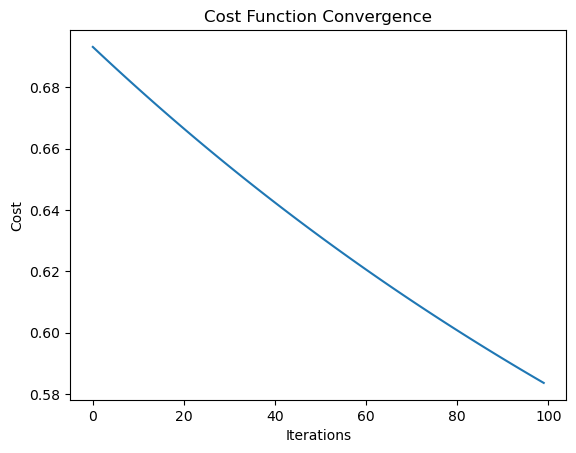

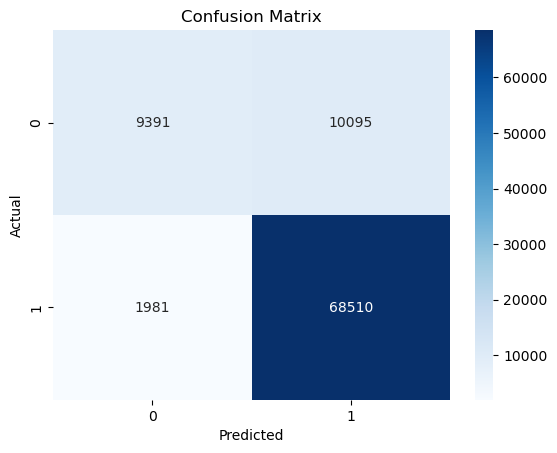

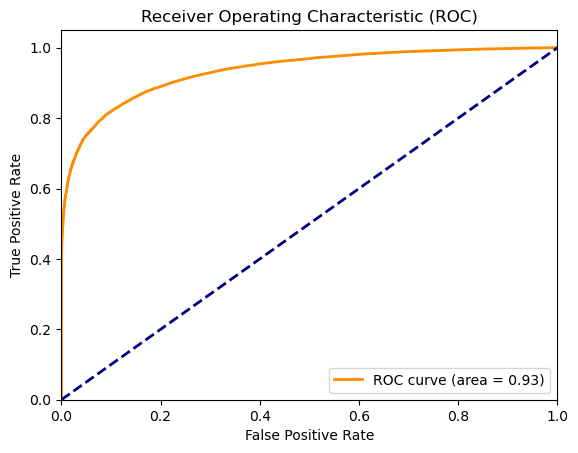

In [22]:
#Using the basic custom model with 100 iterations
#split the data
X = df.drop(columns=[y_label])
Y = df[y_label]

#Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#PCA
pca = PCA(n_components=0.5)
X_pca = pca.fit_transform(X_scaled)

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pca, Y, test_size=0.2, random_state=42)

#create and fit the model
log_reg = CustomLogisticRegression(learning_rate=0.01, n_iters=100)
log_reg.fit(X_train, y_train)

#Evalauations
log_reg.evaluate(X_test, y_test, threshold=0.5)

#Cost history
log_reg.plot_cost_history()

#Confusion matrix
log_reg.plot_confusion_matrix(X_test, y_test, threshold=0.5)

#ROC curve
auc_score = log_reg.plot_roc_curve(X_test, y_test)

Iteration 0/1000: Cost = 0.6931471805599445
Iteration 100/1000: Cost = 0.5827660882988597
Iteration 200/1000: Cost = 0.5136489593409783
Iteration 300/1000: Cost = 0.4677639534957851
Iteration 400/1000: Cost = 0.43548148562824646
Iteration 500/1000: Cost = 0.4116324450507528
Iteration 600/1000: Cost = 0.3933054046075534
Iteration 700/1000: Cost = 0.37876947847397485
Iteration 800/1000: Cost = 0.366942870415313
Iteration 900/1000: Cost = 0.3571190375948858
R2 Score: 0.25658257713512633
Accuracy: 0.8738677662069195
F1 Score: 0.9227995945771289


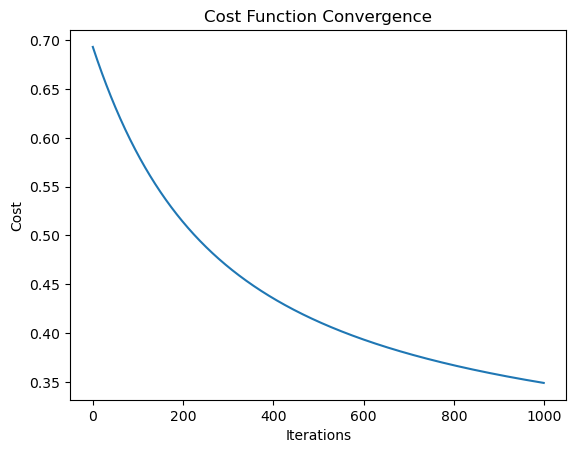

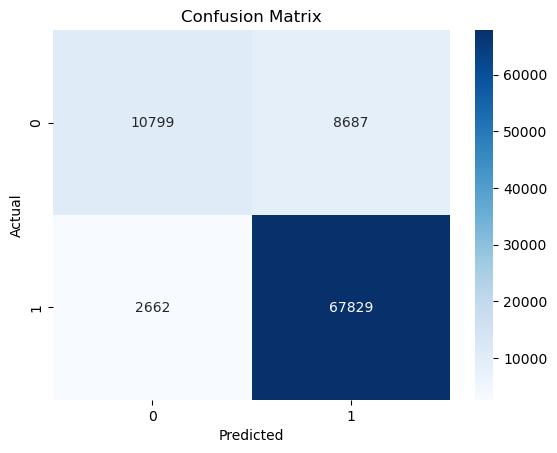

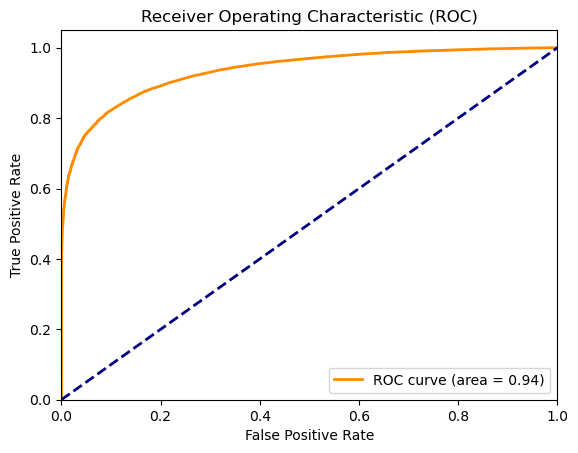

In [23]:
#Using the basic custom model with 1000 iterations and a learning rate of 0.01
#split the data
X = df.drop(columns=[y_label])
Y = df[y_label]

#Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#PCA
pca = PCA(n_components=0.5)
X_pca = pca.fit_transform(X_scaled)

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pca, Y, test_size=0.2, random_state=42)

#create and fit the model
log_reg = CustomLogisticRegression(learning_rate=0.01, n_iters=1000)
log_reg.fit(X_train, y_train)

#Evalauations
log_reg.evaluate(X_test, y_test, threshold=0.5)

#Cost history
log_reg.plot_cost_history()

#Confusion matrix
log_reg.plot_confusion_matrix(X_test, y_test, threshold=0.5)

#ROC curve
auc_score = log_reg.plot_roc_curve(X_test, y_test)

Iteration 0/1000: Cost = 0.6931471805599445
Iteration 100/1000: Cost = 0.6795080949365901
Iteration 200/1000: Cost = 0.6665350357104411
Iteration 300/1000: Cost = 0.6541939034247707
Iteration 400/1000: Cost = 0.6424515151654072
Iteration 500/1000: Cost = 0.631275763633637
Iteration 600/1000: Cost = 0.6206357379825307
Iteration 700/1000: Cost = 0.6105018100772577
Iteration 800/1000: Cost = 0.6008456902884717
Iteration 900/1000: Cost = 0.5916404570839164
R2 Score: 0.20896036668286067
Accuracy: 0.8657879235804705
F1 Score: 0.9190052047003273


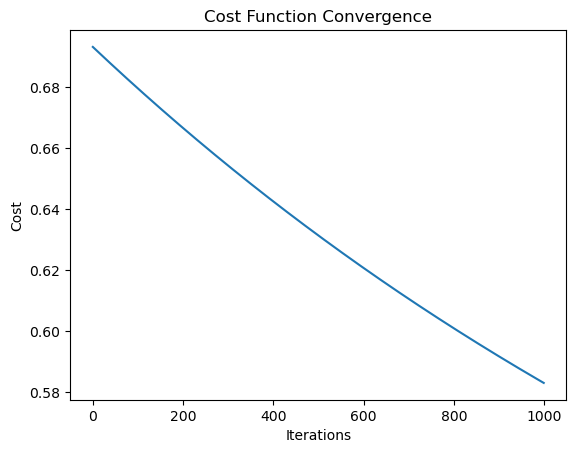

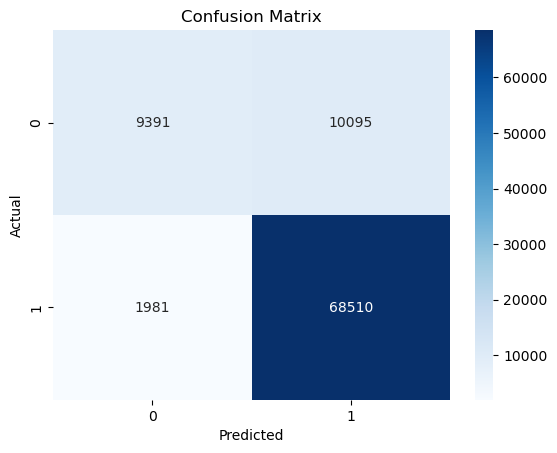

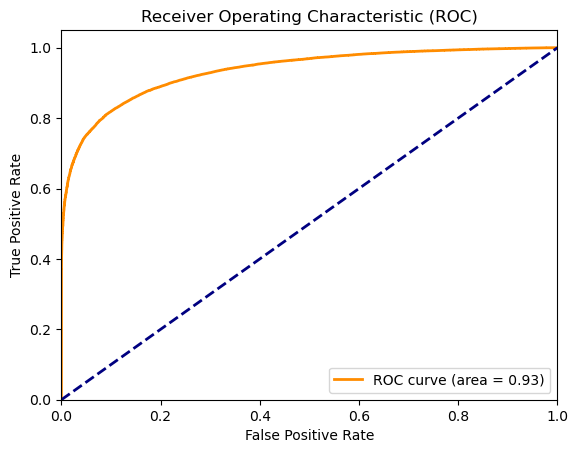

In [24]:
#Using the basic custom model with too low learning rate
#split the data
X = df.drop(columns=[y_label])
Y = df[y_label]

#Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#PCA
pca = PCA(n_components=0.5)
X_pca = pca.fit_transform(X_scaled)

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pca, Y, test_size=0.2, random_state=42)

#create and fit the model
log_reg = CustomLogisticRegression(learning_rate=0.001, n_iters=1000)
log_reg.fit(X_train, y_train)

#Evalauations
log_reg.evaluate(X_test, y_test, threshold=0.5)

#Cost history
log_reg.plot_cost_history()

#Confusion matrix
log_reg.plot_confusion_matrix(X_test, y_test, threshold=0.5)

#ROC curve
auc_score = log_reg.plot_roc_curve(X_test, y_test)

Iteration 0/1000: Cost = 0.6931471805599445
Iteration 100/1000: Cost = 0.34832165381669644
Iteration 200/1000: Cost = 0.3050828189982947
Iteration 300/1000: Cost = 0.2878447903933133
Iteration 400/1000: Cost = 0.27869951573584295
Iteration 500/1000: Cost = 0.2731514605536435
Iteration 600/1000: Cost = 0.26951007170173025
Iteration 700/1000: Cost = 0.2669928484754995
Iteration 800/1000: Cost = 0.26518758420746275
Iteration 900/1000: Cost = 0.2638569753371613
R2 Score: 0.30558039476689347
Accuracy: 0.8821810018115741
F1 Score: 0.9260641228614671


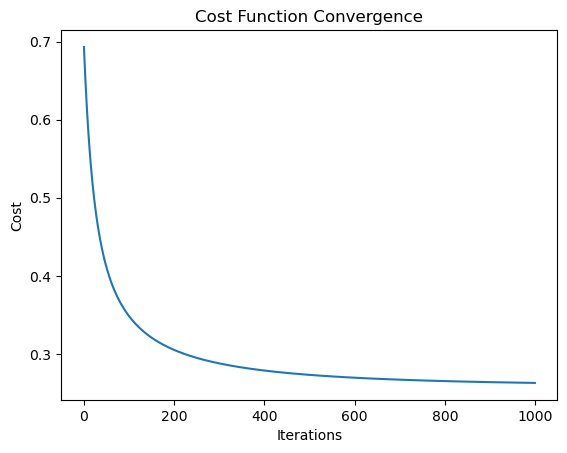

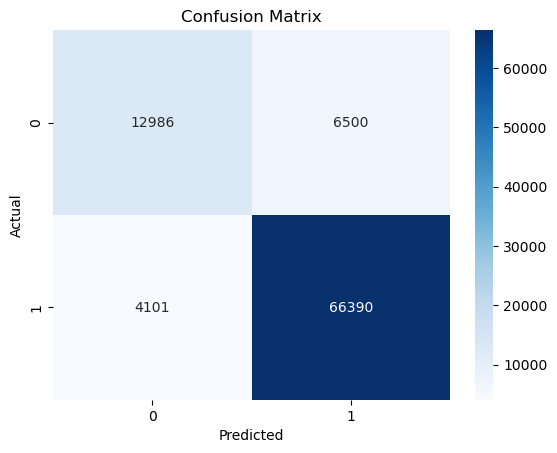

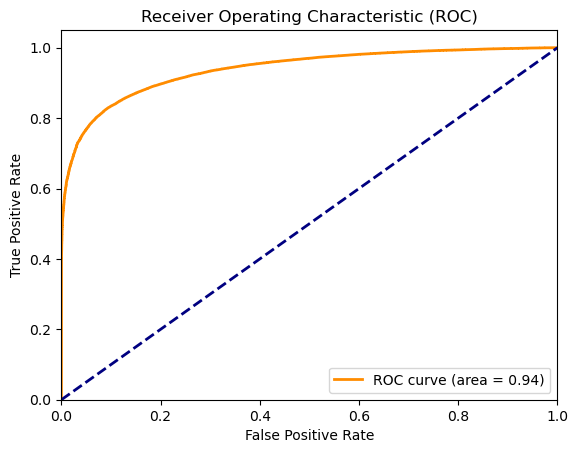

In [25]:
#Using the basic custom model with too high learning rate
#split the data
X = df.drop(columns=[y_label])
Y = df[y_label]

#Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#PCA
pca = PCA(n_components=0.5)
X_pca = pca.fit_transform(X_scaled)

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pca, Y, test_size=0.2, random_state=42)

#create and fit the model
log_reg = CustomLogisticRegression(learning_rate=0.1, n_iters=1000)
log_reg.fit(X_train, y_train)

#Evalauations
log_reg.evaluate(X_test, y_test, threshold=0.5)

#Cost history
log_reg.plot_cost_history()

#Confusion matrix
log_reg.plot_confusion_matrix(X_test, y_test, threshold=0.5)

#ROC curve
auc_score = log_reg.plot_roc_curve(X_test, y_test)

Iteration 0/1000: Cost = 0.4248438475619711
Iteration 100/1000: Cost = 0.3667165780643048
Iteration 200/1000: Cost = 0.32513099506913273
Iteration 300/1000: Cost = 0.29461914114624066
Iteration 400/1000: Cost = 0.2715819087894317
Iteration 500/1000: Cost = 0.25371215678103826
Iteration 600/1000: Cost = 0.23951604648750394
Iteration 700/1000: Cost = 0.22800332761976788
Iteration 800/1000: Cost = 0.21849961831114129
Iteration 900/1000: Cost = 0.21053333808281416
R2 Score: 0.23752059193346298
Accuracy: 0.8706336063660713
F1 Score: 0.9212417283516247


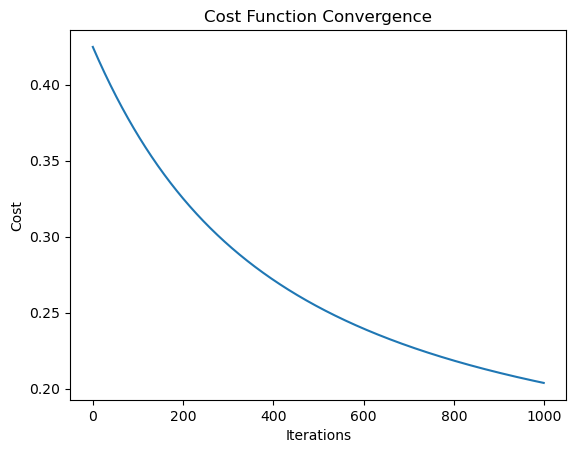

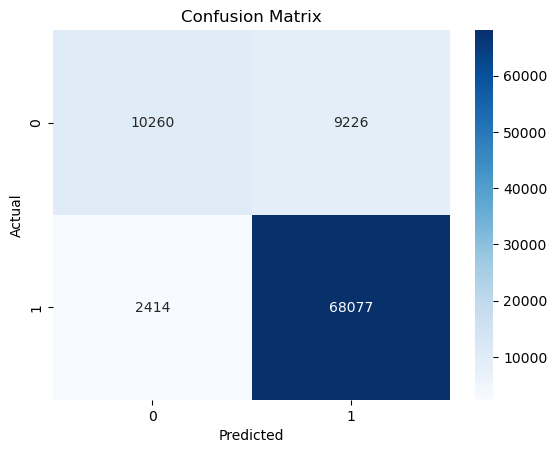

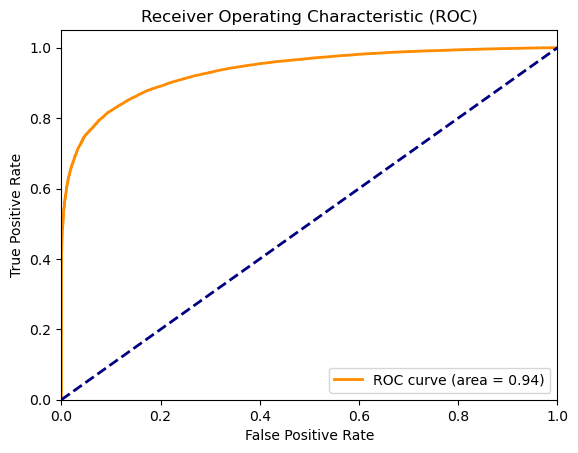

In [26]:
#Using the optimised custom model
#split the data
X = df.drop(columns=[y_label])
Y = df[y_label]

#Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#PCA
pca = PCA(n_components=0.5)
X_pca = pca.fit_transform(X_scaled)

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pca, Y, test_size=0.2, random_state=42)

#create and fit the model
class_weights = {0: 0.3, 1: 0.7}
log_reg = CustomLogisticRegressionOptimized(learning_rate=0.01, n_iters=1000, class_weights=class_weights, reg_lambda=0.01)
log_reg.fit(X_train, y_train)

# Predictions and evaluation
y_pred = log_reg.predict(X_test)

#Evalauations
evaluation_results = log_reg.evaluate(X_test, y_test, threshold=0.5)

#Cost history
log_reg.plot_cost_history()

#Confusion matrix
log_reg.plot_confusion_matrix(X_test, y_test, threshold=0.5)

#ROC curve
auc_score = log_reg.plot_roc_curve(X_test, y_test)

Iteration 0/1000: Cost = 0.4248438475619711
Iteration 100/1000: Cost = 0.3618058117013668
Iteration 200/1000: Cost = 0.31691252389888414
Iteration 300/1000: Cost = 0.28400137237900575
Iteration 400/1000: Cost = 0.2590769051616498
Iteration 500/1000: Cost = 0.23962306452207535
Iteration 600/1000: Cost = 0.22403553128327008
Iteration 700/1000: Cost = 0.2112634653659144
Iteration 800/1000: Cost = 0.2005975675674823
Iteration 900/1000: Cost = 0.19154500318363035
R2 Score: 0.7269747274208482
Accuracy: 0.9536770508018716
F1 Score: 0.9707890052282634


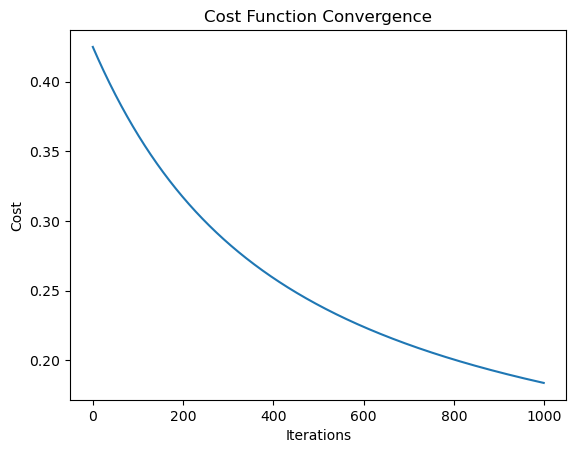

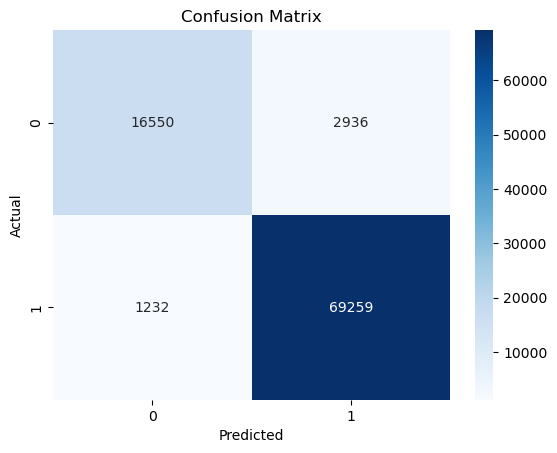

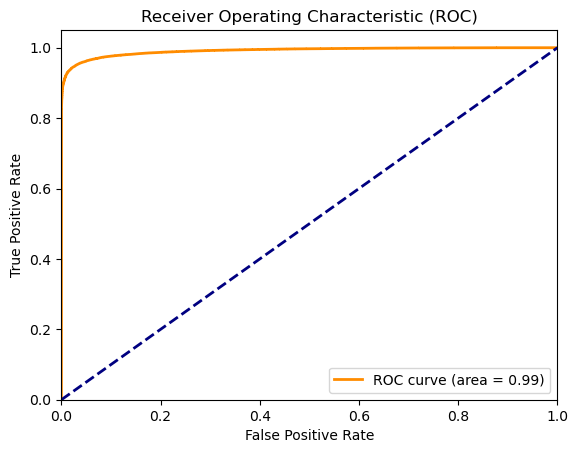

In [27]:
#Using the optimised custom model with more data
#split the data
X = df.drop(columns=[y_label])
Y = df[y_label]

#Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#PCA
pca = PCA(n_components=0.8)
X_pca = pca.fit_transform(X_scaled)

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pca, Y, test_size=0.2, random_state=42)

#create and fit the model
class_weights = {0: 0.3, 1: 0.7}
log_reg = CustomLogisticRegressionOptimized(learning_rate=0.01, n_iters=1000, class_weights=class_weights, reg_lambda=0.01)
log_reg.fit(X_train, y_train)

# Predictions and evaluation
y_pred = log_reg.predict(X_test)

#Evalauations
evaluation_results = log_reg.evaluate(X_test, y_test, threshold=0.5)

#Cost history
log_reg.plot_cost_history()

#Confusion matrix
log_reg.plot_confusion_matrix(X_test, y_test, threshold=0.5)

#ROC curve
auc_score = log_reg.plot_roc_curve(X_test, y_test)

Iteration 0/1000: Cost = 0.4248438475619711
Iteration 100/1000: Cost = 0.36338631981397657
Iteration 200/1000: Cost = 0.31962743482142414
Iteration 300/1000: Cost = 0.2875878780258135
Iteration 400/1000: Cost = 0.26337712053873724
Iteration 500/1000: Cost = 0.24453594987326496
Iteration 600/1000: Cost = 0.22949185990825816
Iteration 700/1000: Cost = 0.21721288273580486
Iteration 800/1000: Cost = 0.20700161174653997
Iteration 900/1000: Cost = 0.19837312856871214
R2 Score: 0.5966850759909219
Accuracy: 0.9315714015804039
F1 Score: 0.9543333951418506


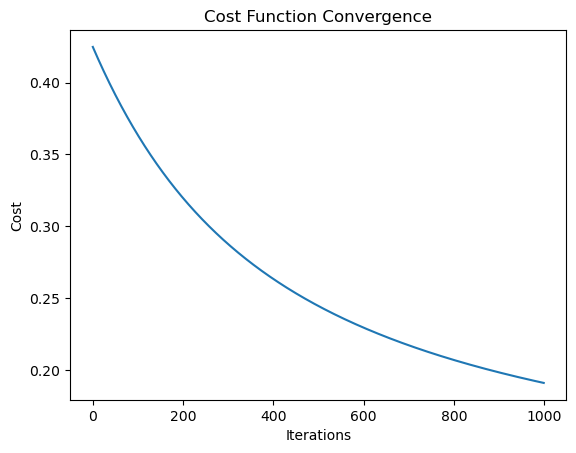

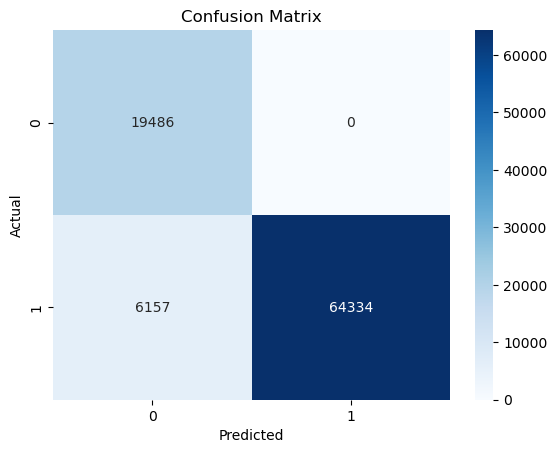

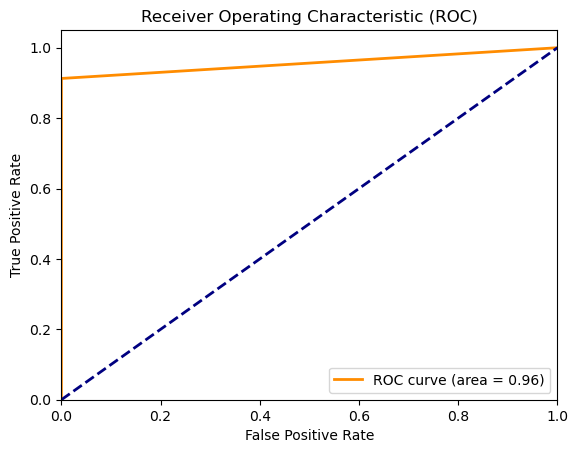

Model saved


In [28]:
#Using the optimised custom model with less features
#split the data
X = df[['Fever','Cough','Breathlessness','Loss_of_Smell_Taste']]
Y = df[y_label]

#Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

#create and fit the model
class_weights = {0: 0.3, 1: 0.7}
log_reg = CustomLogisticRegressionOptimized(learning_rate=0.01, n_iters=1000, class_weights=class_weights, reg_lambda=0.01)
log_reg.fit(X_train, y_train)

# Predictions and evaluation
y_pred = log_reg.predict(X_test)

#Evalauations
evaluation_results = log_reg.evaluate(X_test, y_test, threshold=0.5)

#Cost history
log_reg.plot_cost_history()

#Confusion matrix
log_reg.plot_confusion_matrix(X_test, y_test, threshold=0.5)

#ROC curve
auc_score = log_reg.plot_roc_curve(X_test, y_test)

#save the model, scaler, and PCA using the pickle package 
#This model was chosen to be used in the userinput as it has the smalled input features, as is accurate
#Source: https://saturncloud.io/blog/exporting-machine-learning-models-a-comprehensive-guide-for-data-scientists/
with open('export.pkl', 'wb') as objects:
    pickle.dump({
        'model': log_reg,
        'scaler': scaler
    }, objects)

print("Model saved")

In [29]:
###############################################################################################################################################################
#----------------------------------------------------------------------COMPARING WITH PREBUILT MODEL-----------------------------------------------------------
###############################################################################################################################################################

r2: 0.9324642379968557
accuracy: 0.9885415161652422
F1-score: 0.9926331358832734


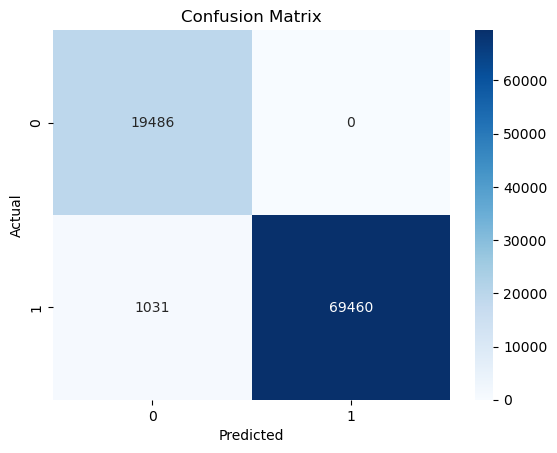

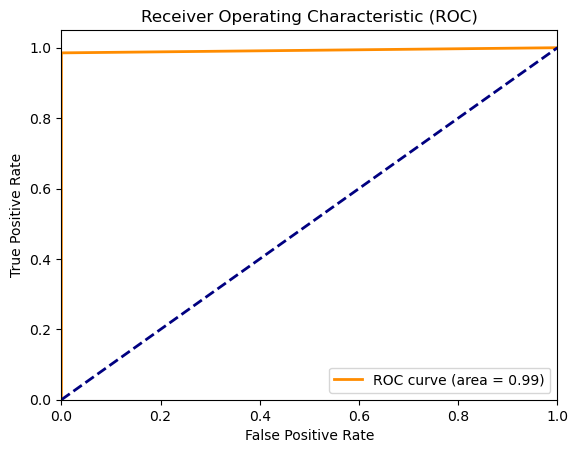

In [30]:
#Comparing the custom models to a pre built model
#now for the first time a prebuild model is imported and used
#this is done to test how the custom models compare to a propper model
#it is important to note that the SKLearn model has almost 3000 lines of code, including comments

#import it here so that it cannot be used able by the custom models
from sklearn.linear_model import LogisticRegression

#split the data
X = df.drop(columns=[y_label])
Y = df[y_label]

#Scaling
#this model preferes the MaxAbsScaler to the StandardScaler, however if the MaxAbsScaler is used with the custom models then they have a negative r2 score
scaler = MaxAbsScaler()
X_scaled = scaler.fit_transform(X)

#PCA
pca = PCA(n_components=0.8)
X_pca = pca.fit_transform(X_scaled)

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pca, Y, test_size=0.2, random_state=42)

#decalre, fit, and get predicitons from the model
SKLearnLR = LogisticRegression(random_state=42, max_iter=1000)
SKLearnLR.fit(X_train, y_train)
y_pred = SKLearnLR.predict(X_test)

#Evalauations
r2_lr = r2_score(y_test, y_pred)
score = accuracy_score(y_test,y_pred)
f1 = f1_score(y_test, y_pred)

print('r2:', r2_lr)
print('accuracy:',score)
print("F1-score:", f1)

#Confusion matrix
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [31]:
###############################################################################################################################################################
#----------------------------------------------------------------------USER INPUT------------------------------------------------------------------------------
###############################################################################################################################################################

In [32]:
#Load the objects using pickle
#Source: https://saturncloud.io/blog/exporting-machine-learning-models-a-comprehensive-guide-for-data-scientists/

#The custom classes need to be instantialised into the current envioment and session inorder for this to work.
#Thus the code up to the beginning of where the model are created needs to have been run

with open('export.pkl', 'rb') as objects:
    objects = pickle.load(objects)

log_reg = objects['model']
scaler = objects['scaler']

In [33]:
#Get user inputs
features = ['Fever', 'Cough', 'Breathlessness', 'Loss of Smell or Taste']
user_inputs = []

for feature in features:
    value = input(f"Does the patient have {feature}? (Only enter 'True' or 'False') ")
    
    #ensure input is True or False
    while value not in ['True', 'False']:
        value = input(f"INCORRRECT INPUT... Does the patient have {feature}? (Only enter 'True' or 'False') ")
    
    #encode the inputs
    #0 = True
    #1 = False
    user_inputs.append(0 if value == 'True' else 1)

user_inputs

[1, 1, 0, 0]

In [34]:
#Use the user inputs
#scale the data
user_input_scaled = scaler.transform([user_inputs])

#create prediciton
prediction = log_reg.predict(user_input_scaled)

#print prediction
if prediction == 0:
    print('The patient has Covid \n')
else:
    print('The patient does not have Covid \n')

The patient does not have Covid 



c:\Users\cybrm\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
